# Kospi200 Daily

In [1]:
import numpy as np
import pandas as pd

# Crawling
from bs4 import BeautifulSoup
from selenium import webdriver

# Crawling: Request
from urllib.request import urlopen
import urllib.request
import urllib.parse
import requests
    
# conda install -c conda-forge tqdm
from tqdm import tqdm
from tqdm import tqdm_notebook

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Utility
import time
import re
import copy

# Palette
import seaborn as sns
sns.set_palette("pastel")

# Jupyter Notebook
%matplotlib inline

# korean Font
matplotlib.font_manager._rebuild()
sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist if f.name.startswith("Malgun")])
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

# Webdriver for crawling
driver = webdriver.Chrome('C:/Users/shoseo/AppData/Local/Programs/Python/chromedriver')

In [2]:
df = pd.read_csv('kospi200.csv', index_col=0)
df.code = df['code'].astype(str).str.zfill(6)
df.index = np.arange(0, len(df))
df.sort_values(by='시가총액(억)', ascending=False)
df.head()

,code,종목,현재가,전일비,등락률,거래량,거래대금(백만),시가총액(억)
0,005930,삼성전자,64800,0,0.00,15295915,983185,3868419
1,000660,SK하이닉스,98000,0,0.00,2564162,249595,713442
2,207940,삼성바이오로직스,809000,3000,-0.37,176409,143548,535275
3,051910,LG화학,720000,11000,1.55,334055,240160,508265
4,035420,NAVER,280000,1000,-0.36,481528,135367,459938


### Single Page Crawling

In [3]:
baseUrl = 'https://finance.naver.com/item/sise_day.nhn?code='
pageUrls = []
codes = []

for i, code in df['code'].iteritems():
    pageUrl = baseUrl + code
    pageUrls.append(pageUrl)
    codes.append(code)

pageUrls[:3]

['https://finance.naver.com/item/sise_day.nhn?code=005930',
 'https://finance.naver.com/item/sise_day.nhn?code=000660',
 'https://finance.naver.com/item/sise_day.nhn?code=207940']

In [4]:
icode = 0
pageCode = codes[icode]

driver.switch_to.window(driver.window_handles[0])
driver.get(str(pageUrls[icode]))

html = driver.page_source
soup = BeautifulSoup(html)
# soup = BeautifulSoup(html, 'html.parser')
# print(soup.prettify())

thead = []
tbody = []

for irow, row in enumerate(soup.select('table.type2 tbody tr')):

    tbody.append({})

    # thead
    if irow == 0:

        cols = row.select('th')

        # Initialize
        thead.append('code')

        for icol, col in enumerate(cols):
            thead.append(col.get_text(strip=True))
    
    # tbody
    else:

        cols = row.select('td')

        # Exception blank column
        if len(cols) < 2:
            continue
        
        # Initialize
        tbody[irow].update({'code':pageCode})

        for icol, col in enumerate(cols):

            # 날짜
            if icol == 0:
                
                element = col.find('span')
                text = element.get_text(strip=True)
                text = re.sub('\.', '-', text)
                tbody[irow].update({ thead[icol+1] : text })

            # 전일비
            elif icol == 2:
                
                element = col.find('span')
                classes = ' '.join(element.get('class'))

                text = element.get_text(strip=True)
                text = re.sub('\D+', '', text)
                text = float(text)

                # 상승
                if classes.find('red02') > 0:
                    text = '%.0f' % float(+text)
                # 하락
                elif classes.find('nv01') > 0:
                    text = '%.0f' % float(-text)
                else:
                    text = '%.0f' % float(text)

                tbody[irow].update({ thead[icol+1] : text })

            else:

                element = col.find('span')
                text = element.get_text(strip=True)
                text = re.sub('\D+', '', text)
                text = int(text)
                tbody[irow].update({ thead[icol+1] : text })
# thead
tbody[3]

{'code': '005930',
 '날짜': '2020-11-19',
 '종가': 64600,
 '전일비': '-200',
 '시가': 64100,
 '고가': 64800,
 '저가': 63900,
 '거래량': 16590290}

### Multiple Page Crawling

In [5]:
baseUrl = 'https://finance.naver.com/item/sise_day.nhn?code='
pageUrls = []
codes = []

for i, code in df['code'].iteritems():
    pageUrl = baseUrl + code
    pageUrls.append(pageUrl)
    codes.append(code)

pageUrls[:3]

['https://finance.naver.com/item/sise_day.nhn?code=005930',
 'https://finance.naver.com/item/sise_day.nhn?code=000660',
 'https://finance.naver.com/item/sise_day.nhn?code=207940']

In [16]:
pageUrls = pageUrls[:1]
max_page = 20

thead = []
tbody = []

for icode, pageUrl in enumerate(pageUrls):

    time.sleep(.1)
    # if icode > 2:
    #     continue

    pageCode = codes[icode]

    driver.switch_to.window(driver.window_handles[0])
    driver.get(str(pageUrl))

    html = driver.page_source
    soup = BeautifulSoup(html)
    # soup = BeautifulSoup(html, 'html.parser')
    # print(soup.prettify())

    # pagination
    navi = []

    for icol, col in enumerate(soup.select('table.Nnavi tbody td')):

        element = col.a
        href = element.get('href')
        match = re.compile(r"page=(\d+)").search(href)
        page = match.group(1) if match != None else '000000'
        navi.append(int(page))

    # max_page = max(navi)

    # loop
    for page_num in np.arange(max_page):
        page_num = page_num + 1
        
        # if page_num > 3:
            # continue

        view_base = f"https://finance.naver.com/item/sise_day.nhn?code={pageCode}&page="
        view_url = view_base + str(page_num)

        # selenium
        driver.get(view_url)
        html = driver.page_source
        soup = BeautifulSoup(html)
        paging = len(tbody)

        for irow, row in enumerate(soup.select('table.type2 tbody tr')):
            irow = irow + paging

            tbody.append({})

            # thead
            if irow == 0:

                cols = row.select('th')

                # Initialize
                thead.append('code')

                for icol, col in enumerate(cols):
                    thead.append(col.get_text(strip=True))
            
            # tbody
            else:

                cols = row.select('td')

                # Exception blank column
                if len(cols) < 2:
                    continue
                
                # Initialize
                tbody[irow].update({'code':pageCode})

                for icol, col in enumerate(cols):

                    # 날짜
                    if icol == 0:

                        element = col.find('span')
                        text = element.get_text(strip=True)
                        text = re.sub('\.', '-', text)
                        tbody[irow].update({ thead[icol+1] : text })

                    # 전일비
                    elif icol == 2:
                        
                        element = col.find('span')
                        classes = ' '.join(element.get('class'))

                        text = element.get_text(strip=True)
                        text = re.sub('\D+', '', text)
                        text = float(text)

                        # 상승
                        if classes.find('red02') > 0:
                            text = '%.0f' % float(+text)
                        # 하락
                        elif classes.find('nv01') > 0:
                            text = '%.0f' % float(-text)
                        else:
                            text = '%.0f' % float(text)

                        tbody[irow].update({ thead[icol+1] : text })
                        
                    else:

                        element = col.find('span')
                        text = element.get_text(strip=True)
                        text = re.sub('\D+', '', text)
                        text = int(text)
                        tbody[irow].update({ thead[icol+1] : text })
# thead
tbody[3]

{'code': '005930',
 '날짜': '2020-11-19',
 '종가': 64600,
 '전일비': '-200',
 '시가': 64100,
 '고가': 64800,
 '저가': 63900,
 '거래량': 16590290}

### DataFrame

In [7]:
df = pd.DataFrame(tbody)

df = df[df.code.isnull() == False]

df['날짜'] = pd.to_datetime(df['날짜'])
df['종가'] = df['종가'].astype(int)
df['전일비'] = df['전일비'].apply(lambda x: '{:}'.format(x))
df['시가'] = df['시가'].astype(int)
df['고가'] = df['고가'].astype(int)
df['저가'] = df['저가'].astype(int)
df['거래량'] = df['거래량'].astype(int)

df.index = np.arange(0, len(df))
df.head()

,code,날짜,종가,전일비,시가,고가,저가,거래량
0,005930,2020-11-20,64500,-100,63900,65200,63900,10665405
1,005930,2020-11-19,64600,-200,64100,64800,63900,16590290
2,005930,2020-11-18,64800,-900,65700,66200,64700,22963790
3,005930,2020-11-17,65700,-600,67000,67000,65600,30204089
4,005930,2020-11-16,66300,3100,64000,66700,63900,36354334


### Export and Import

In [8]:
df.index = np.arange(1, len(df)+1)
df.to_csv('kospi200-daily.csv', sep=',', encoding='utf8')

In [9]:
df_day = pd.read_csv('kospi200-daily.csv', index_col=0)
df_day.code = df_day['code'].astype(str).str.zfill(6)
df_day.index = np.arange(0, len(df_day))
df_day.head()

,code,날짜,종가,전일비,시가,고가,저가,거래량
0,005930,2020-11-20,64500,-100,63900,65200,63900,10665405
1,005930,2020-11-19,64600,-200,64100,64800,63900,16590290
2,005930,2020-11-18,64800,-900,65700,66200,64700,22963790
3,005930,2020-11-17,65700,-600,67000,67000,65600,30204089
4,005930,2020-11-16,66300,3100,64000,66700,63900,36354334


In [10]:
df_200 = pd.read_csv('kospi200.csv', index_col=0)
df_200.code = df_200['code'].astype(str).str.zfill(6)
df_200.index = np.arange(0, len(df_200))
df_200.head()

,code,종목,현재가,전일비,등락률,거래량,거래대금(백만),시가총액(억)
0,005930,삼성전자,64800,0,0.00,15295915,983185,3868419
1,000660,SK하이닉스,98000,0,0.00,2564162,249595,713442
2,207940,삼성바이오로직스,809000,3000,-0.37,176409,143548,535275
3,051910,LG화학,720000,11000,1.55,334055,240160,508265
4,035420,NAVER,280000,1000,-0.36,481528,135367,459938


### Visualization

In [11]:
df = pd.merge(df_day, df_200, on='code')

# Drop and Replace
df.drop(['거래량_x', '현재가', '전일비_y', '등락률', '거래량_y', '거래대금(백만)', '시가총액(억)'], inplace=True, axis=1)
df.rename(columns={
    '전일비_x': '전일비',
}, inplace=True)

# Seperate Datetime
df['년'] = pd.DatetimeIndex(df['날짜']).year
df['월'] = pd.DatetimeIndex(df['날짜']).month
df['일'] = pd.DatetimeIndex(df['날짜']).day

# Reorder
df = df[['code', '종목', '날짜', '년', '월', '일', '종가', '전일비', '시가', '고가', '저가']]

# Moving Average
for col, rows in df.iteritems():
    if col not in '종가':
        continue
    
    movingIdxs = [5, 15, 30]

    for movingIdx in movingIdxs:
        df[f"{movingIdx}일 이동평균선"] = np.nan

        for idx, row in enumerate(rows):
            if idx < movingIdx:
                continue
            
            movingAvg = df['종가'].iloc[idx-movingIdx:idx].sum() / movingIdx
            df[f"{movingIdx}일 이동평균선"].iloc[idx] = movingAvg

df.head(20)

,code,종목,날짜,년,월,일,종가,전일비,시가,고가,저가,5일 이동평균선,15일 이동평균선,30일 이동평균선
0,005930,삼성전자,2020-11-20,2020,11,20,64500,-100,63900,65200,63900,NaN,NaN,NaN
1,005930,삼성전자,2020-11-19,2020,11,19,64600,-200,64100,64800,63900,NaN,NaN,NaN
2,005930,삼성전자,2020-11-18,2020,11,18,64800,-900,65700,66200,64700,NaN,NaN,NaN
3,005930,삼성전자,2020-11-17,2020,11,17,65700,-600,67000,67000,65600,NaN,NaN,NaN
4,005930,삼성전자,2020-11-16,2020,11,16,66300,3100,64000,66700,63900,NaN,NaN,NaN
5,005930,삼성전자,2020-11-13,2020,11,13,63200,2200,61300,63200,61000,65180.0,NaN,NaN
6,005930,삼성전자,2020-11-12,2020,11,12,61000,-300,61000,61400,60700,64920.0,NaN,NaN
7,005930,삼성전자,2020-11-11,2020,11,11,61300,1100,60700,61400,60400,64200.0,NaN,NaN
8,005930,삼성전자,2020-11-10,2020,11,10,60200,0,60500,60500,59500,63500.0,NaN,NaN
9,005930,삼성전자,2020-11-09,2020,11,9,60200,100,60700,60900,60100,62400.0,NaN,NaN


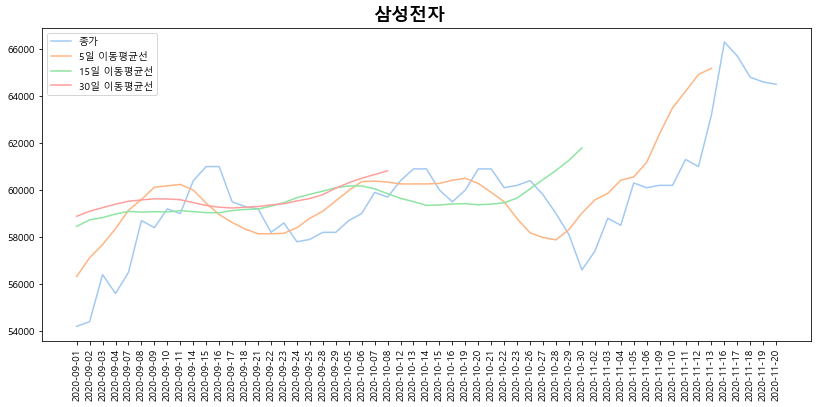

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

# Axis1
df1 = df.query("(종목 in '삼성전자') and (월 in ['9', '10', '11'])")
df1Size = df1.shape[0]
ax1 = axes
ax1.plot(df1['날짜'], df1['종가'], label="종가")
ax1.tick_params(axis='x', rotation=90)
ax1.invert_xaxis()

# Axis MovingAverage
movingIndexs = [5, 15, 30]
for movingIndex in movingIndexs:
    ax1.plot(df1['날짜'], df1[f"{movingIndex}일 이동평균선"], label=f"{movingIndex}일 이동평균선")

ax1.legend()

# Figure
fig.suptitle("삼성전자", fontsize=18, fontweight='bold')
fig.tight_layout(pad=3)

plt.show()